<a href="https://colab.research.google.com/github/javachka11/AutoCor/blob/main/AutoCor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Конгруэнтный генератор Фибоначчи

def get_next(x1, x2, m=10):
  return (x1 + x2) % (2**m)

def get_sequence(n, m, k1, k2, x0):
  # n - length of the sequence
  # m - power of 2 in the generating formula
  # k1 and k2 - lags, k2 >= k1 >= 1
  # x0 - initial sequence, should be of length k2
  sequence = np.zeros(n)
  sequence[0:k2] = x0[0:k2]
  for i in range(k2, n):
    sequence[i] = get_next(sequence[i - k1], sequence[i - k2], m=m)
  return sequence


k1 = 24
k2 = 55
m = 8
x0 = np.random.randint(low=0, high=2**m, size=k2)
seq = get_sequence(1000, m, k1, k2, x0)

#поможет понять, сколько байтов надо выделить для разрядности
order = int(max(seq)) // 256 + 1

In [3]:
def bit3_seq(x, mode=1):
  assert (x // 8 + 1) <= mode
  #переводим число из 10-ной системы в 2-ную систему счисления
  arr = list(bin(x))[2:]

  #элементы битового списка - строки,
  #поэтому переведём их в тип int
  arr = np.array(arr, dtype='int8')

  #теперь надо добавить нули спереди так, чтобы было ровно 3*mode бит в записи
  arr = list(np.zeros(3*mode, dtype='int'))[len(arr):3*mode] + list(arr)
  
  return np.array(arr)

def byte_seq(x, mode=1):
  assert (x // 256 + 1) <= mode
  #переводим число из 10-ной системы в 2-ную систему счисления
  arr = list(bin(x))[2:]

  #элементы битового списка - строки,
  #поэтому переведём их в тип int
  arr = np.array(arr, dtype='int8')

  #теперь надо добавить нули спереди так, чтобы было ровно 8*mode бит в записи
  arr = list(np.zeros(8*mode, dtype='int'))[len(arr):8*mode] + list(arr)
  
  return np.array(arr)


#нормировка битовой АКФ (1->1, 0->-1)
#передаётся сразу вся битовая последовательность
def norm_bit(arr):
  return 2 * arr - 1

#нормировка символьной АКФ
#передаётся двоичное представление числа ai
def norm_sym(x):
  sum = 0
  for i in range(len(x)):
    sum += (-1)**(x[-i-1]) * 2**i
  return sum

def cor_splash(arr):
  splashes = []
  sum = np.sum(arr ** 2)
  for j in range(len(arr)+1):
    s = 0
    for i in range(len(arr)):
      s += arr[i]*arr[(i+j) % len(arr)]
    splashes.append(s / sum)
  return np.array(splashes)

In [4]:
_rg = np.random.default_rng(1)
_arr1 = 256 * _rg.random(10)
_arr2 = 256 * _rg.random(1000)

In [5]:
def gen(a, b, m, n=1000):
  x = []
  x.append(2)
  for i in range(n):
    x.append((a * x[i] + b) % m)
  return np.array(x) % 256

In [6]:
_g = gen(143, 171, 256)

In [7]:
def main(ds=1, mode=1):
  if ds == 1 and mode == 1:
    mode_desc = "Битовая АКФ для КГФ"
    arr = seq[:10]
  elif ds == 1 and mode == 2:
    mode_desc = "Символьная АКФ для КГФ"
    arr = seq[:1000]
  elif ds == 2 and mode == 1:
    mode_desc = "Битовая АКФ для np.random.default_rng(1)"
    arr = _arr1
  elif ds == 2 and mode == 2:
    mode_desc = "Символьная АКФ для np.random.default_rng(1)"
    arr = _arr2
  elif ds == 3 and mode == 1:
    mode_desc = "Битовая АКФ для плохого генератора"
    arr = _g[:10]
  elif ds == 3 and mode == 2:
    mode_desc = "Символьная АКФ для плохого генератора"
    arr = _g
  
  arr = np.array(arr, dtype='int32')
  bts = []
  for x in arr:
    bts.append(byte_seq(x, mode=order))
  arr = np.array(bts)
  
  if mode == 1:
    arr = np.reshape(arr, newshape=arr.size)
    arr = np.array(list(map(norm_bit, arr)))
    cs = cor_splash(arr)
  elif mode == 2:
    di = np.array(list(map(norm_sym, arr)))
    cs = cor_splash(di)

  plt.bar(range(len(cs)), cs)
  plt.title(mode_desc)
  plt.show()

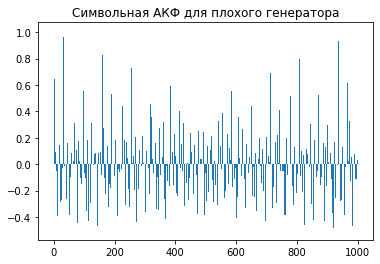

In [13]:
main(ds=3, mode=2)